**Problem Statement**

- Salary prediction of nurses
- part-time/non-regular jobs are out of scope, target nurses are
    - `REGISTERED NURSE`,
    - `LICENSED VOCATIONAL NURSE`
    - `NURSING ASSISTANT`
    - `NURSE MANAGER`
    - `PUBLIC HEALTH NURSE`
- only nurses who work more than 5 years

# Import

In [1]:
#data stuff
import pandas as pd

#Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

#other
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
# from pythainlp import word_tokenize

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Load raw data

- including not only nurses but also other jobs 
- uppercase all names and job titles 

In [2]:
rawdata = pd.read_csv('./old_data//san-francisco-payroll_2011-2019.csv',low_memory=False)
rawdata['Employee Name'] = rawdata['Employee Name'].apply(lambda x: x.upper())
rawdata['Job Title'] = rawdata['Job Title'].apply(lambda x: x.upper())
rawdata

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,JANET LEE MILLER,COURT STAFF ATTORNEY II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
3,KRISTIAN C SMOCK,"STATIONARY ENG, SEWAGE PLANT",106816.03,0.0,0.0,38729.65,106816.03,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,94039.13,14947.99,1241.69,35330.26,110228.81,145559.07,2019,FT
...,...,...,...,...,...,...,...,...,...,...
357402,HOWARD CHUCK,CUSTODIAN,46106.73,890.49,4839.07,Not Provided,51836.29,51836.29,2011,NaN
357403,BING KEUNG MAK,CUSTODIAN,48472.4,1972.35,1390.5,Not Provided,51835.25,51835.25,2011,NaN
357404,QIN MING ZHU,CUSTODIAN,46046.29,1853.97,3934.44,Not Provided,51834.70,51834.70,2011,NaN
357405,JOSE ALONZO,CUSTODIAN,47798.87,0.0,4032.55,Not Provided,51831.42,51831.42,2011,NaN


# filter only target nurses

In [3]:
NURSES = ['REGISTERED NURSE',
'LICENSED VOCATIONAL NURSE',
'NURSING ASSISTANT',
'NURSE MANAGER',
'PUBLIC HEALTH NURSE']


data = rawdata[rawdata['Job Title'].isin(NURSES)].reset_index(drop=True)
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16497,NERIZA SAMALA,LICENSED VOCATIONAL NURSE,49883.47,0.0,484.88,Not Provided,50368.35,50368.35,2011,NaN
16498,DAWA SUBHAR,REGISTERED NURSE,48489.15,0.0,1862.64,Not Provided,50351.79,50351.79,2011,NaN
16499,PETER SCHULZE,REGISTERED NURSE,44727.19,567.18,4647.31,Not Provided,49941.68,49941.68,2011,NaN
16500,MICHAEL ENWEREUZO SR,LICENSED VOCATIONAL NURSE,43183.6,5962.24,3660.48,Not Provided,52806.32,52806.32,2011,NaN


In [4]:
## count of each nurse
data['Job Title'].value_counts()

REGISTERED NURSE             11939
LICENSED VOCATIONAL NURSE     2013
NURSING ASSISTANT             1228
NURSE MANAGER                  799
PUBLIC HEALTH NURSE            523
Name: Job Title, dtype: int64

In [5]:
## count of each year
data['Year'].value_counts()

2019    2032
2018    1946
2017    1908
2016    1862
2015    1802
2013    1762
2012    1758
2014    1754
2011    1678
Name: Year, dtype: int64

## check duplicated employee name

In [6]:
grouped = data.groupby(['Employee Name', 'Year']).count()['Job Title']
grouped

Employee Name        Year
AACE WU              2018    1
                     2019    1
AARON CRAMER         2011    1
                     2012    1
AARON LY             2015    1
                            ..
ZOSIMA P PANGILINAN  2017    1
                     2018    1
                     2019    1
ZOSIMA PANGILINAN    2011    1
                     2012    1
Name: Job Title, Length: 16497, dtype: int64

In [7]:
grouped[grouped > 1]

Employee Name        Year
MARGARITA HERRERA    2012    2
MARGARITA L HERRERA  2017    2
MARIA CRUZ           2012    2
NANCY KRAUSS         2012    2
XING C CUI           2017    2
Name: Job Title, dtype: int64

- `MARGARITA HERRERA` and `MARGARITA L HERRERA` may be identical

In [8]:
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


In [9]:
data[data['Employee Name'] == 'MARGARITA L HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN


In [10]:
## rename `MARGARITA L HERRERA`
data['Employee Name'] = data['Employee Name'].replace('MARGARITA L HERRERA', 'MARGARITA HERRERA')

In [11]:
## replaced
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


In [12]:
data[data['Employee Name'] == 'NANCY KRAUSS']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
14483,NANCY KRAUSS,LICENSED VOCATIONAL NURSE,26211.6,723.29,441.68,14714.37,27376.57,42090.94,2012,NaN
14556,NANCY KRAUSS,LICENSED VOCATIONAL NURSE,2690.4,0.0,107.64,664.84,2798.04,3462.88,2012,NaN


## filter only those who work more than 1 year

In [13]:
data['Employee Name']=data['Employee Name'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z0-9 ]', '', regex=True)
data['Job Title']=data['Job Title'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z ]', '', regex=True)
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16497,NERIZA SAMALA,LICENSED VOCATIONAL NURSE,49883.47,0.0,484.88,Not Provided,50368.35,50368.35,2011,NaN
16498,DAWA SUBHAR,REGISTERED NURSE,48489.15,0.0,1862.64,Not Provided,50351.79,50351.79,2011,NaN
16499,PETER SCHULZE,REGISTERED NURSE,44727.19,567.18,4647.31,Not Provided,49941.68,49941.68,2011,NaN
16500,MICHAEL ENWEREUZO SR,LICENSED VOCATIONAL NURSE,43183.6,5962.24,3660.48,Not Provided,52806.32,52806.32,2011,NaN


In [14]:
df=data[['Employee Name', 'Job Title', 'Total Pay & Benefits', 'Year', 'Status']]
df.columns=['Employee Name', 'Job Title', 'Salary', 'Year', 'Status']
df=df[df['Salary']!=0.0]
df

,Employee Name,Job Title,Salary,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,145387.50,2019,PT
...,...,...,...,...,...
16497,NERIZA SAMALA,LICENSED VOCATIONAL NURSE,50368.35,2011,NaN
16498,DAWA SUBHAR,REGISTERED NURSE,50351.79,2011,NaN
16499,PETER SCHULZE,REGISTERED NURSE,49941.68,2011,NaN
16500,MICHAEL ENWEREUZO SR,LICENSED VOCATIONAL NURSE,52806.32,2011,NaN


In [15]:
start_salary=df.sort_values(by='Year').groupby(by='Employee Name').agg({'Salary':'first', 'Year':'first'}).reset_index()
start_salary.columns=['Employee Name', 'Start Salary', 'Start Year']
start_salary

,Employee Name,Start Salary,Start Year
0,AACE WU,121348.48,2018
1,AARON CRAMER,106385.49,2011
2,AARON LY,54164.61,2015
3,AARON R RAINEY,174662.29,2013
4,AARON RAINEY,78260.44,2011
...,...,...,...
4583,ZEXU FANG,119085.50,2011
4584,ZHALYA GUSEYNOVA,28588.30,2013
4585,ZIYING TAN,64718.51,2019
4586,ZOSIMA P PANGILINAN,107608.78,2013


In [16]:
merge_df=df.merge(start_salary, on ='Employee Name', how='left').sort_values(['Employee Name','Year']).reset_index(drop=True)
merge_df.columns=['Employee Name', 'Job Title', 'End Salary', 'End Year', 'Status','Start Salary', 'Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year
0,AACE WU,REGISTERED NURSE,121348.48,2018,PT,121348.48,2018
1,AACE WU,REGISTERED NURSE,86623.20,2019,PT,121348.48,2018
2,AARON CRAMER,REGISTERED NURSE,106385.49,2011,NaN,106385.49,2011
3,AARON CRAMER,REGISTERED NURSE,173747.94,2012,NaN,106385.49,2011
4,AARON LY,REGISTERED NURSE,54164.61,2015,PT,54164.61,2015
...,...,...,...,...,...,...,...
16497,ZOSIMA P PANGILINAN,NURSING ASSISTANT,108824.77,2017,FT,107608.78,2013
16498,ZOSIMA P PANGILINAN,NURSING ASSISTANT,124500.40,2018,FT,107608.78,2013
16499,ZOSIMA P PANGILINAN,NURSING ASSISTANT,79010.87,2019,PT,107608.78,2013
16500,ZOSIMA PANGILINAN,NURSING ASSISTANT,71418.77,2011,NaN,71418.77,2011


In [17]:
merge_df['Total Year']=merge_df['End Year']-merge_df['Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year
0,AACE WU,REGISTERED NURSE,121348.48,2018,PT,121348.48,2018,0
1,AACE WU,REGISTERED NURSE,86623.20,2019,PT,121348.48,2018,1
2,AARON CRAMER,REGISTERED NURSE,106385.49,2011,NaN,106385.49,2011,0
3,AARON CRAMER,REGISTERED NURSE,173747.94,2012,NaN,106385.49,2011,1
4,AARON LY,REGISTERED NURSE,54164.61,2015,PT,54164.61,2015,0
...,...,...,...,...,...,...,...,...
16497,ZOSIMA P PANGILINAN,NURSING ASSISTANT,108824.77,2017,FT,107608.78,2013,4
16498,ZOSIMA P PANGILINAN,NURSING ASSISTANT,124500.40,2018,FT,107608.78,2013,5
16499,ZOSIMA P PANGILINAN,NURSING ASSISTANT,79010.87,2019,PT,107608.78,2013,6
16500,ZOSIMA PANGILINAN,NURSING ASSISTANT,71418.77,2011,NaN,71418.77,2011,0


In [18]:
merge_df['Increase Percentage']=round((merge_df['End Salary']-merge_df['Start Salary'])/merge_df['Start Salary']*100,2)
merge_df=merge_df[merge_df['Total Year']!=0].reset_index(drop=True)
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year,Increase Percentage
0,AACE WU,REGISTERED NURSE,86623.20,2019,PT,121348.48,2018,1,-28.62
1,AARON CRAMER,REGISTERED NURSE,173747.94,2012,NaN,106385.49,2011,1,63.32
2,AARON LY,REGISTERED NURSE,149338.07,2016,NaN,54164.61,2015,1,175.71
3,AARON LY,REGISTERED NURSE,163583.77,2017,FT,54164.61,2015,2,202.01
4,AARON LY,REGISTERED NURSE,174131.10,2018,FT,54164.61,2015,3,221.49
...,...,...,...,...,...,...,...,...,...
11908,ZOSIMA P PANGILINAN,NURSING ASSISTANT,104456.45,2016,NaN,107608.78,2013,3,-2.93
11909,ZOSIMA P PANGILINAN,NURSING ASSISTANT,108824.77,2017,FT,107608.78,2013,4,1.13
11910,ZOSIMA P PANGILINAN,NURSING ASSISTANT,124500.40,2018,FT,107608.78,2013,5,15.70
11911,ZOSIMA P PANGILINAN,NURSING ASSISTANT,79010.87,2019,PT,107608.78,2013,6,-26.58


In [19]:
merge_df=merge_df[['Employee Name', 'Job Title', 'Status','Start Salary', 'Start Year', 'End Salary', 'End Year', 'Total Year', 'Increase Percentage']]

In [20]:
merge_df

,Employee Name,Job Title,Status,Start Salary,Start Year,End Salary,End Year,Total Year,Increase Percentage
0,AACE WU,REGISTERED NURSE,PT,121348.48,2018,86623.20,2019,1,-28.62
1,AARON CRAMER,REGISTERED NURSE,NaN,106385.49,2011,173747.94,2012,1,63.32
2,AARON LY,REGISTERED NURSE,NaN,54164.61,2015,149338.07,2016,1,175.71
3,AARON LY,REGISTERED NURSE,FT,54164.61,2015,163583.77,2017,2,202.01
4,AARON LY,REGISTERED NURSE,FT,54164.61,2015,174131.10,2018,3,221.49
...,...,...,...,...,...,...,...,...,...
11908,ZOSIMA P PANGILINAN,NURSING ASSISTANT,NaN,107608.78,2013,104456.45,2016,3,-2.93
11909,ZOSIMA P PANGILINAN,NURSING ASSISTANT,FT,107608.78,2013,108824.77,2017,4,1.13
11910,ZOSIMA P PANGILINAN,NURSING ASSISTANT,FT,107608.78,2013,124500.40,2018,5,15.70
11911,ZOSIMA P PANGILINAN,NURSING ASSISTANT,PT,107608.78,2013,79010.87,2019,6,-26.58


# EDA

- distribution of `Total Pay` by job

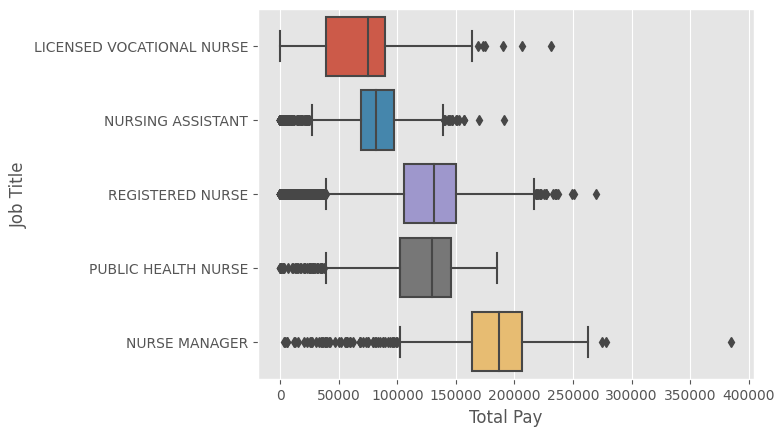

In [21]:
sns.boxplot(x='Total Pay', y='Job Title', data=data);

/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


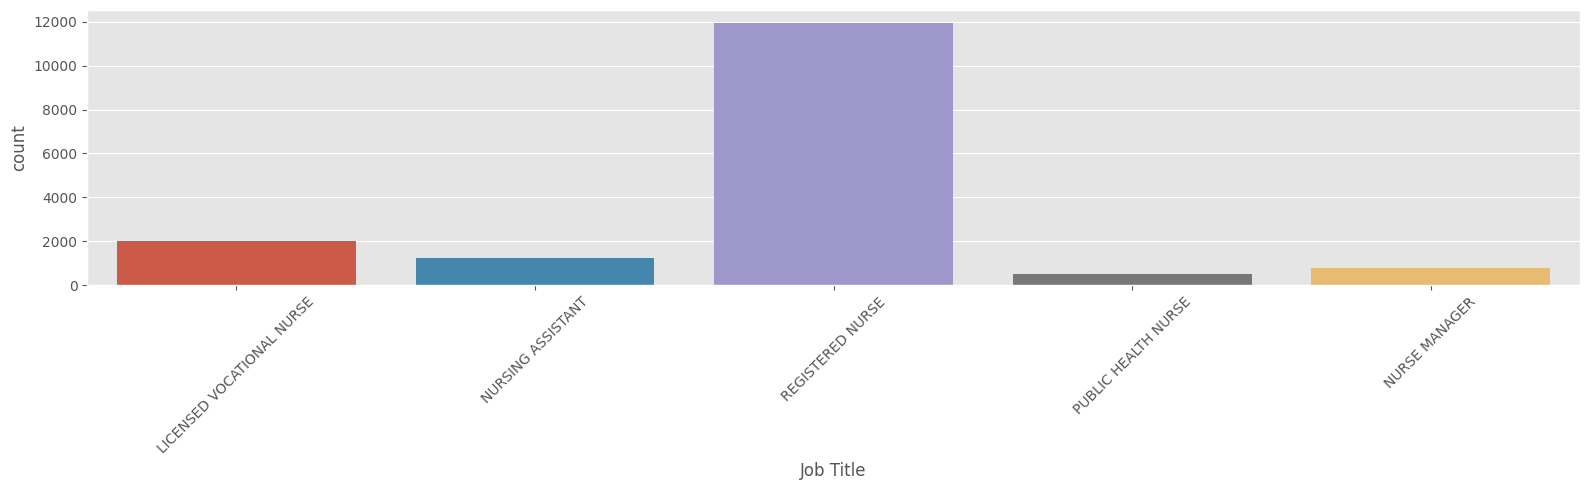

In [22]:
plt.figure(figsize=(16,5))
sns.countplot('Job Title', data = data)
plt.xticks(rotation = 45)
plt.tight_layout();

/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


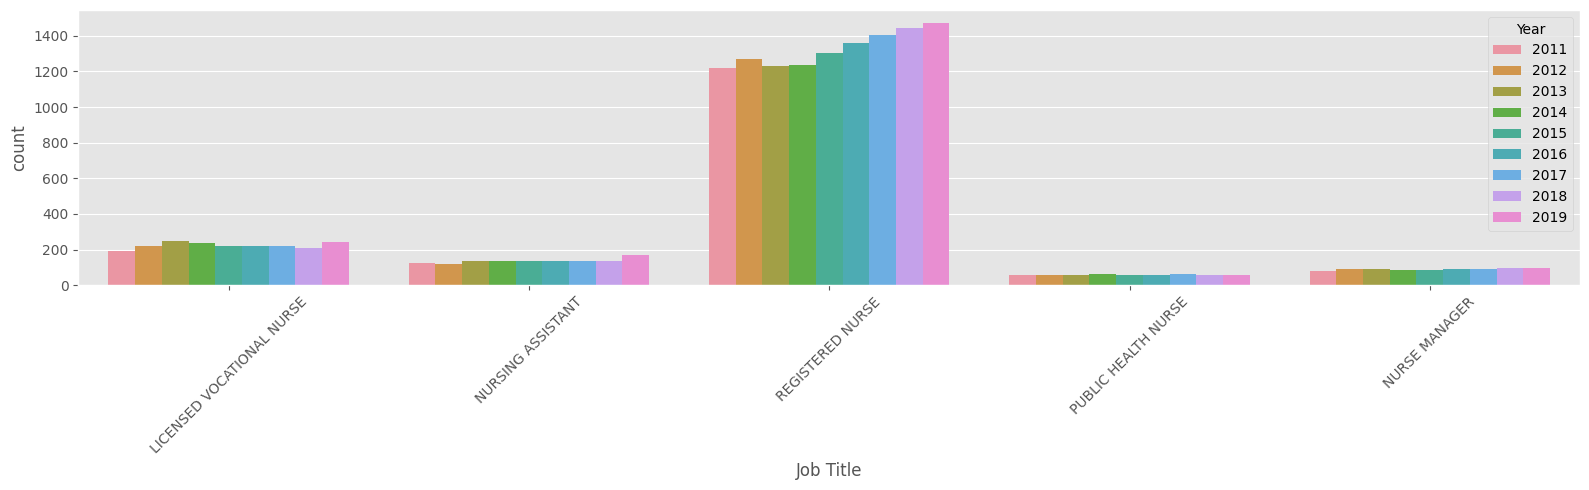

In [23]:
plt.figure(figsize=(16,5))
sns.countplot('Job Title', data = data, hue = 'Year')
plt.xticks(rotation = 45)
plt.tight_layout()

In [24]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'Status', 'Start Salary', 'Start Year',
       'End Salary', 'End Year', 'Total Year', 'Increase Percentage'],
      dtype='object')

In [25]:
merge_df

,Employee Name,Job Title,Status,Start Salary,Start Year,End Salary,End Year,Total Year,Increase Percentage
0,AACE WU,REGISTERED NURSE,PT,121348.48,2018,86623.20,2019,1,-28.62
1,AARON CRAMER,REGISTERED NURSE,NaN,106385.49,2011,173747.94,2012,1,63.32
2,AARON LY,REGISTERED NURSE,NaN,54164.61,2015,149338.07,2016,1,175.71
3,AARON LY,REGISTERED NURSE,FT,54164.61,2015,163583.77,2017,2,202.01
4,AARON LY,REGISTERED NURSE,FT,54164.61,2015,174131.10,2018,3,221.49
...,...,...,...,...,...,...,...,...,...
11908,ZOSIMA P PANGILINAN,NURSING ASSISTANT,NaN,107608.78,2013,104456.45,2016,3,-2.93
11909,ZOSIMA P PANGILINAN,NURSING ASSISTANT,FT,107608.78,2013,108824.77,2017,4,1.13
11910,ZOSIMA P PANGILINAN,NURSING ASSISTANT,FT,107608.78,2013,124500.40,2018,5,15.70
11911,ZOSIMA P PANGILINAN,NURSING ASSISTANT,PT,107608.78,2013,79010.87,2019,6,-26.58


# Adding Carrer Level & Type

In [26]:
merge_df['Job Title'].value_counts()

REGISTERED NURSE             8623
LICENSED VOCATIONAL NURSE    1419
NURSING ASSISTANT             882
NURSE MANAGER                 609
PUBLIC HEALTH NURSE           380
Name: Job Title, dtype: int64

In [27]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'Status', 'Start Salary', 'Start Year',
       'End Salary', 'End Year', 'Total Year', 'Increase Percentage'],
      dtype='object')

In [28]:
main_df=merge_df[[ 'Total Year', 'Increase Percentage','Start Salary','End Salary', 'Job Title']]
main_df

,Total Year,Increase Percentage,Start Salary,End Salary,Job Title
0,1,-28.62,121348.48,86623.20,REGISTERED NURSE
1,1,63.32,106385.49,173747.94,REGISTERED NURSE
2,1,175.71,54164.61,149338.07,REGISTERED NURSE
3,2,202.01,54164.61,163583.77,REGISTERED NURSE
4,3,221.49,54164.61,174131.10,REGISTERED NURSE
...,...,...,...,...,...
11908,3,-2.93,107608.78,104456.45,NURSING ASSISTANT
11909,4,1.13,107608.78,108824.77,NURSING ASSISTANT
11910,5,15.70,107608.78,124500.40,NURSING ASSISTANT
11911,6,-26.58,107608.78,79010.87,NURSING ASSISTANT


In [29]:
main_df.corr()

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_74760/2634380414.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  main_df.corr()


,Total Year,Increase Percentage,Start Salary,End Salary
Total Year,1.000000,-0.009154,0.072936,0.177569
Increase Percentage,-0.009154,1.000000,-0.436523,0.048309
Start Salary,0.072936,-0.436523,1.000000,0.490583
End Salary,0.177569,0.048309,0.490583,1.000000


In [30]:
main_df.columns=[ 'Total_Year', 'Increase_Percentage','Start_Salary',  'End_Salary','Job Title']
main_df.columns

Index(['Total_Year', 'Increase_Percentage', 'Start_Salary', 'End_Salary',
       'Job Title'],
      dtype='object')

In [31]:
df_testing=main_df[['Total_Year','Start_Salary','Job Title']]
df_testing

,Total_Year,Start_Salary,Job Title
0,1,121348.48,REGISTERED NURSE
1,1,106385.49,REGISTERED NURSE
2,1,54164.61,REGISTERED NURSE
3,2,54164.61,REGISTERED NURSE
4,3,54164.61,REGISTERED NURSE
...,...,...,...
11908,3,107608.78,NURSING ASSISTANT
11909,4,107608.78,NURSING ASSISTANT
11910,5,107608.78,NURSING ASSISTANT
11911,6,107608.78,NURSING ASSISTANT


In [32]:
df_testing.drop_duplicates(subset=['Total_Year','Start_Salary','Job Title'],inplace=True)
df_testing

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_74760/3150601585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing.drop_duplicates(subset=['Total_Year','Start_Salary','Job Title'],inplace=True)


,Total_Year,Start_Salary,Job Title
0,1,121348.48,REGISTERED NURSE
1,1,106385.49,REGISTERED NURSE
2,1,54164.61,REGISTERED NURSE
3,2,54164.61,REGISTERED NURSE
4,3,54164.61,REGISTERED NURSE
...,...,...,...
11908,3,107608.78,NURSING ASSISTANT
11909,4,107608.78,NURSING ASSISTANT
11910,5,107608.78,NURSING ASSISTANT
11911,6,107608.78,NURSING ASSISTANT


In [33]:
main_df

,Total_Year,Increase_Percentage,Start_Salary,End_Salary,Job Title
0,1,-28.62,121348.48,86623.20,REGISTERED NURSE
1,1,63.32,106385.49,173747.94,REGISTERED NURSE
2,1,175.71,54164.61,149338.07,REGISTERED NURSE
3,2,202.01,54164.61,163583.77,REGISTERED NURSE
4,3,221.49,54164.61,174131.10,REGISTERED NURSE
...,...,...,...,...,...
11908,3,-2.93,107608.78,104456.45,NURSING ASSISTANT
11909,4,1.13,107608.78,108824.77,NURSING ASSISTANT
11910,5,15.70,107608.78,124500.40,NURSING ASSISTANT
11911,6,-26.58,107608.78,79010.87,NURSING ASSISTANT


## Model with Start Salary + Encoding

In [ ]:
main_df

In [ ]:
X=main_df[['Total_Year','Start_Salary']]
y=main_df['End_Salary']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor()
clf.fit(X_train, y_train)

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()